# Prevalence of people with insufficient food consumption released by World Food Programme (WFP)

In this notebook, we create the time-series related to the prevalence of people with insufficient food consumption. 

For more details, see the *README.md*.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import ntpath
import glob
plt.style.use("default")

In [2]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../../packages/")
from MapPlot.MapPlot import draw_adminstratas
from TsIP.TsIP import TsIP

In [3]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

In [4]:
# Load the data released by wfp regarding the prevalence of people with insufficient food consumption stored in the 'WFP_data' folder.
path = "./WFP_data/"
all_folders = glob.glob(path + "*")

dfs = []

for folder in all_folders:
    country = ntpath.basename(folder).split(".")[0]
    all_files = glob.glob(path + country + "/*.csv")
    for filename in all_files:
        df = pd.read_csv(filename)
        df["Country"] = country
        dfs.append(df)

In [5]:
# Concatenate data.
df = pd.concat(dfs, axis = 0, ignore_index = True)
# Delete duplicate rows if exist.
df = df.drop_duplicates()
df.head()

,SvyDate,Date,Dmgrph,DmgrphCode,Mean_crrnt,Pop,PopNmbr,Country
0,2019-7-15_2019-9-8,2019-09-08,CENTRE,900714,22.0938,2623394,579606,Burkina Faso
1,2019-7-15_2019-9-8,2019-09-08,CENTRE-SUD,900718,45.0209,801374,360785,Burkina Faso
2,2019-7-15_2019-9-8,2019-09-08,PLATEAU-CENTRAL,900722,44.7766,872851,390832,Burkina Faso
3,2019-7-15_2019-9-8,2019-09-08,CENTRE-EST,900715,44.1861,2623394,1159174,Burkina Faso
4,2019-7-15_2019-9-8,2019-09-08,EST,900719,51.9179,1633891,848282,Burkina Faso


### Brief items description

- *SvyDate*: reference period of the data collection;
- *Date*: reference date (i.e. the end of the reference period);
- *Dmgrph*: administrative area name;
- *DmgrphCode*: a code for identyfing the adminstrata;
- *Mean_crrnt*: % of people with poor and borderline food consumption during the corresponding SvyDate;
- *Pop*: area population size;
- *PopNmbr*: number of people with poor and borderline food consumption (i.e. Mean_crrnt * Pop);
- *Country*: country name;

N.B. In the following, we will indicate the prevalence of people with poor and borderline food consumption (FCG <= 2) with the 'FCG' notation only (1 = poor, 2 = borderline, 3 = acceptable). 

In [6]:
# Check if the dataframe contains some NaN values.
df.isnull().sum()

SvyDate       0
Date          0
Dmgrph        0
DmgrphCode    0
Mean_crrnt    0
Pop           0
PopNmbr       0
Country       0
dtype: int64

In [7]:
# Let's delete some item columns because they are not of interest in this notebook.
df.drop(["DmgrphCode", "Pop", "PopNmbr"], axis = 1, inplace = True) 

In [8]:
# Rename some columns items.
df.rename(columns = {"Date": "Datetime", "Dmgrph": "AdminStrata", "Mean_crrnt": "FCG"}, inplace = True)

In [9]:
# Check the temporal ranges of the SvyDate column creating two new columns.
df[["SvyDate1", "SvyDate2"]] = df["SvyDate"].apply(lambda x: pd.Series([pd.to_datetime(x.split("_")[0]), pd.to_datetime(x.split("_")[1])]))
# The new column 'SvyDateRange' indicates the coverage of days of the survey [SvyDate1, SvyDate2].
df["SvyDateRange"] = (df["SvyDate2"] - df["SvyDate1"]).dt.days + 1
df.head()

,SvyDate,Datetime,AdminStrata,FCG,Country,SvyDate1,SvyDate2,SvyDateRange
0,2019-7-15_2019-9-8,2019-09-08,CENTRE,22.0938,Burkina Faso,2019-07-15,2019-09-08,56
1,2019-7-15_2019-9-8,2019-09-08,CENTRE-SUD,45.0209,Burkina Faso,2019-07-15,2019-09-08,56
2,2019-7-15_2019-9-8,2019-09-08,PLATEAU-CENTRAL,44.7766,Burkina Faso,2019-07-15,2019-09-08,56
3,2019-7-15_2019-9-8,2019-09-08,CENTRE-EST,44.1861,Burkina Faso,2019-07-15,2019-09-08,56
4,2019-7-15_2019-9-8,2019-09-08,EST,51.9179,Burkina Faso,2019-07-15,2019-09-08,56


In [10]:
# Check what are the temporal coverages of countries.
df.groupby("Country")["SvyDateRange"].unique()

Country
Burkina Faso        [56, 30]
Cameroon            [30, 90]
Mali            [28, 84, 30]
Niger               [28, 84]
Nigeria             [31, 30]
Syria                   [31]
Yemen                   [31]
Name: SvyDateRange, dtype: object

This information about the survey coverage will be useful when we adapt the time-series of other indicators (see other notebooks) to this coverage format.

### Country item

In [11]:
print("The countries are:", ", ".join(df.Country.unique()))

The countries are: Burkina Faso, Cameroon, Mali, Niger, Nigeria, Syria, Yemen


### AdminStrata item

In [12]:
# The strings of the administrative regions of Burkina Faso, we change them to obtain lowercase with first capital letter.
def to_lower(country, admin):
    if country in ["Burkina Faso", "Cameroon", "Mali", "Niger"]:
        admin = admin.lower().title()      
    return admin
    
df["AdminStrata"] = df[["Country", "AdminStrata"]].apply(lambda x: to_lower(*x), axis = 1)

In [13]:
# Rename some regions.
df.replace(["Tombouctou/Taoudeni", "Gao/Menaka"], ["Tombouctou-Taoudeni", "Gao-Menaka"], inplace = True)

In [14]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen (YEM)**: the administrative regions of Yemen are 22, including the capital Sana'a (Amanat Al Asimah) and Socotra archipelago. The FCG dataframe has the values of all the 22 administrative regions.

N.B. Hadramaut and Socotra have identical time-series related to FCG indicator.

In [15]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(22,)


array(['Al Hudaydah', 'Al Jawf', 'Al Maharah', 'Al Mahwit',
       'Amanat Al Asimah', 'Amran', 'Dhamar', 'Hadramaut', 'Hajjah',
       'Ibb', 'Lahj', 'Marib', 'Raymah', "Sa'ada", "Sana'a", 'Socotra',
       'Shabwah', 'Taizz', 'Abyan', 'Aden', 'Al Bayda', "Al Dhale'e"],
      dtype=object)

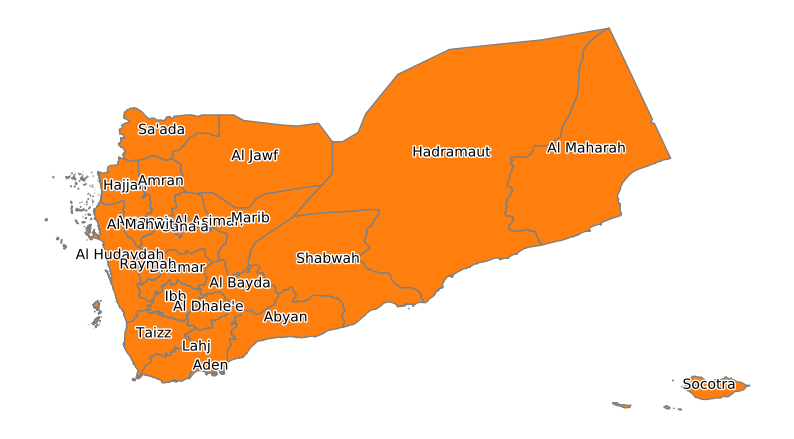

In [16]:
# Plot map.
draw_adminstratas(country = "Yemen", adminstratas = AdminStratas["Yemen"], adminstratas_to_highlight = AdminStratas["Yemen"],
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Yemen/administrative_level_1/Yemen.shp", 
                  figsize = (10, 7), annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Yemen/map_fcs_yemen.png", 
                  dpi = 300)

- **Burkina Faso (BFA)**: Burkina Faso is divided into 13 administrative regions. The FCG dataframe has the values of all 13 administrative regions.

In [17]:
print(AdminStratas["Burkina Faso"].shape)
AdminStratas["Burkina Faso"]

(13,)


array(['Centre', 'Centre-Sud', 'Plateau-Central', 'Centre-Est', 'Est',
       'Sahel', 'Boucle-Du-Mouhoun', 'Centre-Nord', 'Hauts-Bassins',
       'Sud-Ouest', 'Cascades', 'Centre-Ouest', 'Nord'], dtype=object)

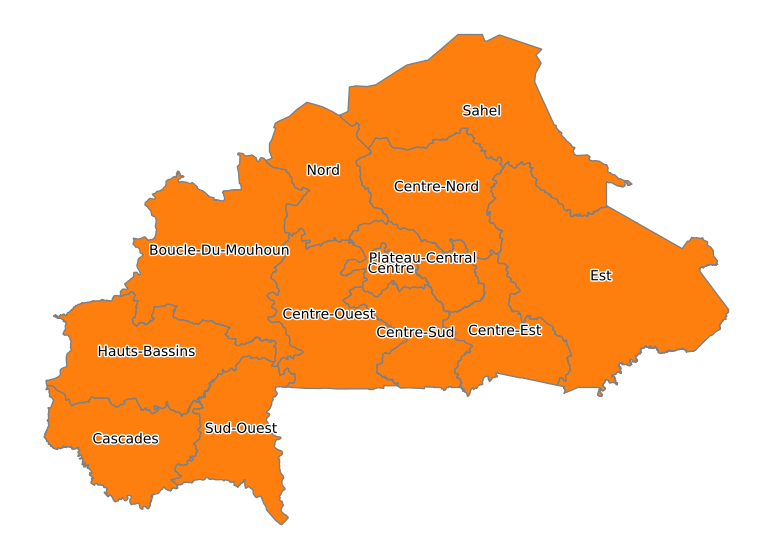

In [18]:
# Plot map.
draw_adminstratas(country = "Burkina Faso", adminstratas = AdminStratas["Burkina Faso"], adminstratas_to_highlight = AdminStratas["Burkina Faso"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Burkina Faso/administrative_level_1/Burkina Faso.shp", 
                  figsize = (10, 7), annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Burkina Faso/map_fcs_burkina.png", 
                  dpi = 300)

- **Syria (SYR)**: the administrative regions of Syria country are 14. The FCG dataframe has the values of 13 administrative regions (Idleb administrative region not included).

In [19]:
print(AdminStratas["Syria"].shape)
AdminStratas["Syria"]

(13,)


array(['Tartous', 'Al-Hasakeh', 'Aleppo', 'As-Sweida', 'Damascus',
       "Dar'a", 'Hama', 'Homs', 'Lattakia', 'Rural Damascus', 'Ar-Raqqa',
       'Deir-ez-Zor', 'Quneitra'], dtype=object)

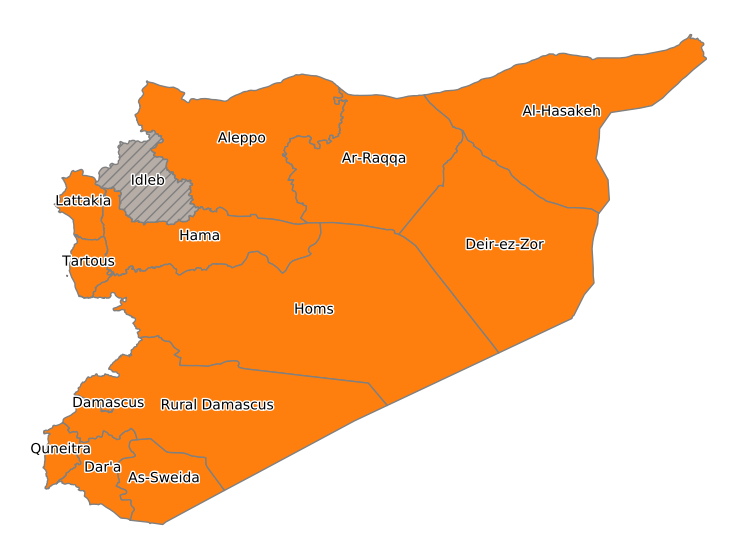

In [20]:
# Plot map.
draw_adminstratas(country = "Syria", adminstratas = AdminStratas["Syria"], adminstratas_to_highlight = AdminStratas["Syria"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Syria/administrative_level_1/Syria.shp", 
                  figsize = (10, 7), annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Syria/map_fcs_syria.png", 
                  dpi = 300)

- **Cameroon (CMR)**: the administrative regions of Cameroon are 10. The FCG dataframe has the values of all the 10 administrative regions.

In [21]:
print(AdminStratas["Cameroon"].shape)
AdminStratas["Cameroon"]

(10,)


array(['South-West', 'Adamawa', 'Central', 'East', 'Far-North',
       'Littoral', 'North', 'South', 'West', 'North-West'], dtype=object)

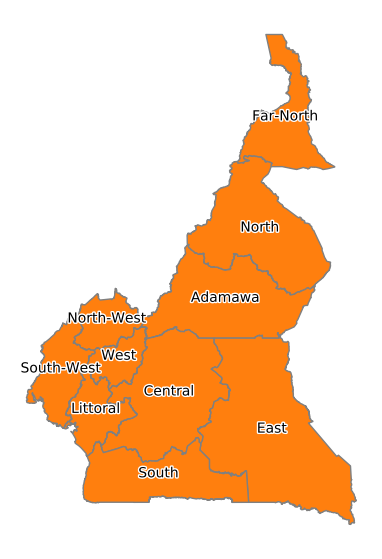

In [22]:
# Plot map.
draw_adminstratas(country = "Cameroon", adminstratas = AdminStratas["Cameroon"], adminstratas_to_highlight = AdminStratas["Cameroon"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Cameroon/administrative_level_1/Cameroon.shp", 
                  figsize = (10, 7), annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Cameroon/map_fcs_cameroon.png", 
                  dpi = 300)

- **Mali (MLI)**: Mali is divided into eight regions and one capital district (Bamako). The AdminStrata items of the FCG dataframe cover all 9 regions.

In [23]:
print(AdminStratas["Mali"].shape)
AdminStratas["Mali"]

(9,)


array(['Mopti', 'Segou', 'Tombouctou-Taoudeni', 'Bamako', 'Kayes',
       'Koulikoro', 'Sikasso', 'Gao-Menaka', 'Kidal'], dtype=object)

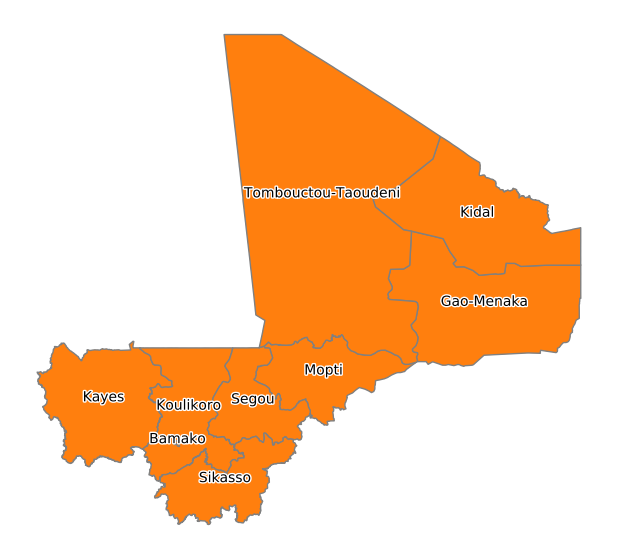

In [24]:
# Plot map.
draw_adminstratas(country = "Mali", adminstratas = AdminStratas["Mali"], adminstratas_to_highlight = AdminStratas["Mali"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Mali/administrative_level_1/Mali.shp", 
                  figsize = (10, 7), annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Mali/map_fcs_mali.png", 
                  dpi = 300)

- **Niger (NER)**: the administrative regions of Niger are 8. The FCG dataframe has the values of all the 8 administrative regions.

In [25]:
print(AdminStratas["Niger"].shape)
AdminStratas["Niger"]

(8,)


array(['Diffa', 'Maradi', 'Tahoua', 'Tillaberi', 'Agadez', 'Dosso',
       'Niamey', 'Zinder'], dtype=object)

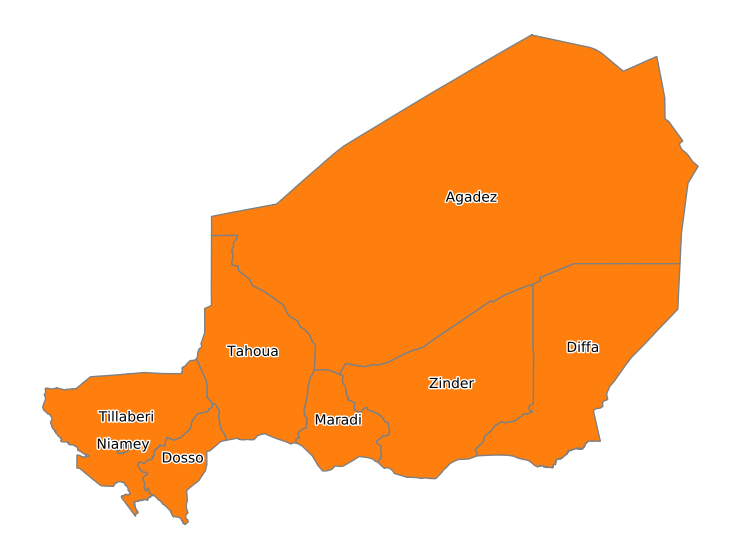

In [26]:
# Plot map.
draw_adminstratas(country = "Niger", adminstratas = AdminStratas["Niger"], adminstratas_to_highlight = AdminStratas["Niger"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Niger/administrative_level_1", figsize = (10, 7), annotation = True, 
                  annotation_selected = True, path_to_save = PATH_TO_SAVE_DATA + "Niger/map_fcs_niger.png", dpi = 300)

- **Nigeria (NGA)**: Nigeria is divided into 36 administrative regions. It also includes The Federal Capital Territory that is is under the direct control of the federal government. The AdminStrata items of the FCG dataframe cover 3 administrative regions: Adamawa, Borno and Yobe.

In [27]:
print(AdminStratas["Nigeria"].shape)
AdminStratas["Nigeria"]

(3,)


array(['Adamawa', 'Borno', 'Yobe'], dtype=object)

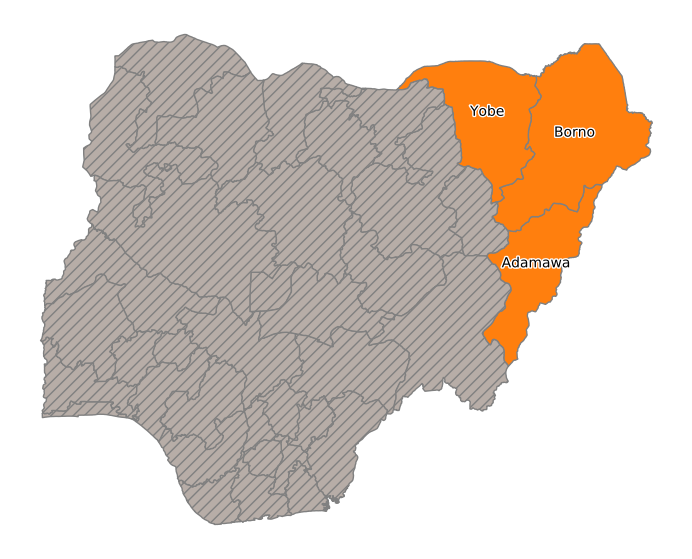

In [28]:
# Plot map.
draw_adminstratas(country = "Nigeria", adminstratas = AdminStratas["Nigeria"], adminstratas_to_highlight = AdminStratas["Nigeria"], 
                  folder_to_shapefiles = "../1. Shape Files/output_shapefiles/Nigeria/administrative_level_1", 
                  figsize = (10, 7), annotation = True, annotation_selected = True, path_to_save = PATH_TO_SAVE_DATA + "Nigeria/map_fcs_nigeria.png", 
                  dpi = 300)

## Data analysis

In [29]:
# Check the min e max values of the FCG column (% of people with poor and borderline food consumption).
print("min: %f, max: %f" % (df["FCG"].min(), df["FCG"].max()))

min: 0.000000, max: 93.358900


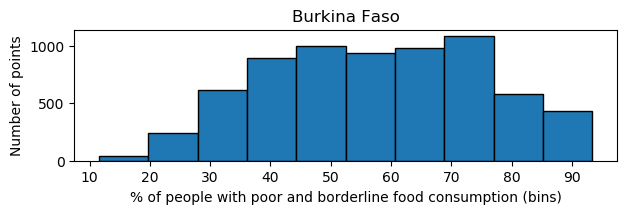

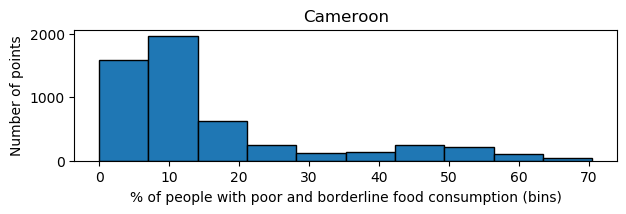

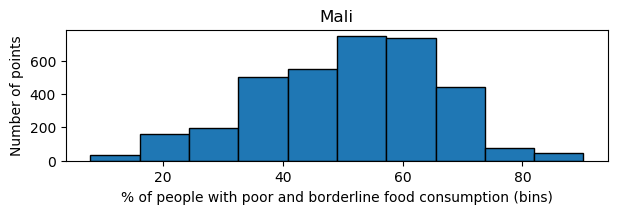

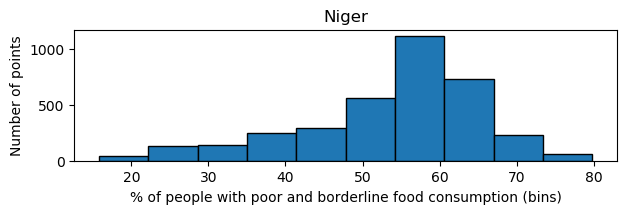

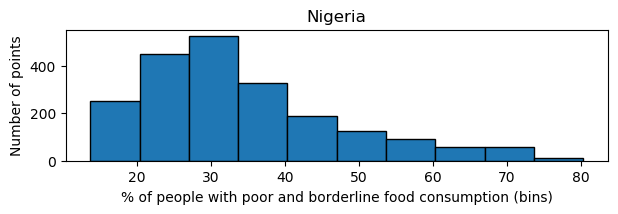

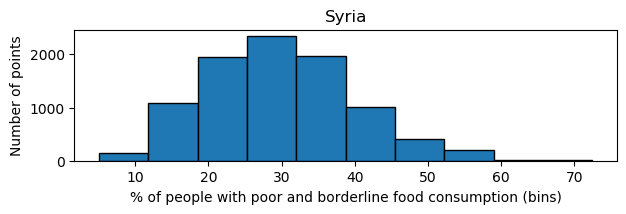

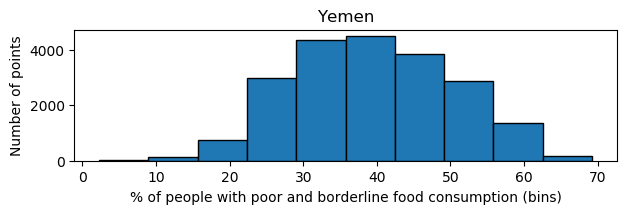

In [30]:
# Create an histogram referred to the values of the FCG for each country.
def hist_fcs(group):
    # Plot hist.
    fig, ax = plt.subplots(figsize = (7, 1.7))
    data = group["FCG"].dropna().values
    ax.hist(data, ec = "k")
    ax.set_title(group.name)
    ax.set_ylabel("Number of points")
    ax.set_xlabel("% of people with poor and borderline food consumption (bins)")
    plt.show()

df.groupby("Country").apply(hist_fcs);

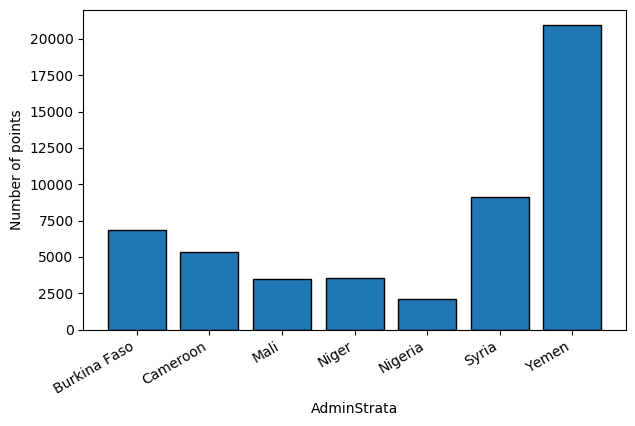

In [31]:
# Create an histogram referred to the number of total points for each country.
n_points = df.groupby("Country")["FCG"].count()

fig, ax = plt.subplots(figsize = (7, 4.7))
ax.bar(n_points.index, n_points.values, ec = "k")
ax.set_ylabel("Number of points")
ax.set_xlabel("AdminStrata")
fig.autofmt_xdate()
plt.show()

## Creation of the time-series

We create the time-series based on the FCG and SvyDateRange values.

In [32]:
not_unique = df.set_index(["Country", "AdminStrata", "Datetime"])
not_unique.index.is_unique

False

In [33]:
mask = not_unique.index.value_counts() > 1
mask = mask[mask].index

not_unique.loc[mask]

SvyDate        FCG   SvyDate1  \
Country AdminStrata    Datetime                                                
Syria   Deir-ez-Zor    2020-08-24  2020-7-25_2020-8-24  52.824533 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  53.303758 2020-07-25   
        Aleppo         2020-08-24  2020-7-25_2020-8-24  53.981450 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  54.198501 2020-07-25   
        Deir-ez-Zor    2020-07-02    2020-6-2_2020-7-2  39.204172 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  38.630914 2020-06-02   
        Rural Damascus 2020-07-02    2020-6-2_2020-7-2  45.016002 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  45.202141 2020-06-02   
        Damascus       2020-08-24  2020-7-25_2020-8-24  39.430700 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  41.024290 2020-07-25   
        Ar-Raqqa       2020-08-24  2020-7-25_2020-8-24  53.297106 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  53.064928 2020-07-25   
                       2020-07-02    2020-6-2_2020-7-2  39.204172 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  38.630914 2020-06-02   
        Hama           2020-08-24  2020-7-25_2020-8-24  51.866948 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  51.780885 2020-07-25   
        Dar'a          2020-08-24  2020-7-25_2020-8-24  33.930242 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  32.455196 2020-07-25   
        Al-Hasakeh     2020-07-02    2020-6-2_2020-7-2  34.396728 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  35.333333 2020-06-02   
        Tartous        2020-07-02    2020-6-2_2020-7-2  31.053459 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  30.691531 2020-06-02   
        Homs           2020-08-24  2020-7-25_2020-8-24  53.689023 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  53.419249 2020-07-25   
        Dar'a          2020-07-02    2020-6-2_2020-7-2  30.061892 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  29.639922 2020-06-02   
        Rural Damascus 2020-08-24  2020-7-25_2020-8-24  57.612047 2020-07-25   
                       2020-08-24  2020-7-25_2020-8-24  57.312100 2020-07-25   
        Quneitra       2020-07-02    2020-6-2_2020-7-2  35.164835 2020-06-02   
                       2020-07-02    2020-6-2_2020-7-2  36.559140 2020-06-02   

                                    SvyDate2  SvyDateRange  
Country AdminStrata    Datetime                             
Syria   Deir-ez-Zor    2020-08-24 2020-08-24            31  
                       2020-08-24 2020-08-24            31  
        Aleppo         2020-08-24 2020-08-24            31  
                       2020-08-24 2020-08-24            31  
        Deir-ez-Zor    2020-07-02 2020-07-02            31  
                       2020-07-02 2020-07-02            31  
        Rural Damascus 2020-07-02 2020-07-02            31  
                       2020-07-02 2020-07-02            31  
        Damascus       2020-08-24 2020-08-24            31  
                       2020-08-24 2020-08-24            31  
        Ar-Raqqa       2020-08-24 2020-08-24            31  
                       2020-08-24 2020-08-24            31  
                       2020-07-02 2020-07-02            31  
                       2020-07-02 2020-07-02            31  
        Hama           2020-08-24 2020-08-24            31  
                       2020-08-24 2020-08-24            31  
        Dar'a          2020-08-24 2020-08-24            31  
                       2020-08-24 2020-08-24            31  
        Al-Hasakeh     2020-07-02 2020-07-02            31  
                       2020-07-02 2020-07-02            31  
        Tartous        2020-07-02 2020-07-02            31  
                       2020-07-02 2020-07-02            31  
        Homs          

In [34]:
# Delete the unused columns.
df.drop(["SvyDate", "SvyDate1", "SvyDate2"], axis = 1, inplace = True) 
# Creation of an accurate datetime format.
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.sort_values("Datetime", ascending = True, inplace = True) 
# Create time-series.
df = df.groupby(["Country", "AdminStrata"]).apply(lambda group: group.set_index("Datetime").resample("D").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,FCG,SvyDateRange
0,Burkina Faso,Boucle-Du-Mouhoun,2019-09-08,30.9217,56.0
1,Burkina Faso,Boucle-Du-Mouhoun,2019-09-09,31.1039,56.0
2,Burkina Faso,Boucle-Du-Mouhoun,2019-09-10,32.0303,56.0
3,Burkina Faso,Boucle-Du-Mouhoun,2019-09-11,32.1673,56.0
4,Burkina Faso,Boucle-Du-Mouhoun,2019-09-12,31.7701,56.0


In [35]:
# Create a dataframe with multi-index column in order to have a summary dataframe of the time-series.
df = df.set_index(["Datetime", "Country", "AdminStrata"]).unstack(["Country", "AdminStrata"]).reorder_levels([1, 2, 0], axis = 1).sort_index(axis = 1, level = [0, 1, 2])
df.columns.rename("Country", level = 0, inplace = True)
df.columns.rename("AdminStrata", level = 1, inplace = True)
df.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
df.index.freq = freq
df.head()

Country          Burkina Faso                                            \
AdminStrata Boucle-Du-Mouhoun              Cascades              Centre   
Indicator                 FCG SvyDateRange      FCG SvyDateRange    FCG   
Datetime                                                                  
2018-07-02                NaN          NaN      NaN          NaN    NaN   
2018-07-03                NaN          NaN      NaN          NaN    NaN   
2018-07-04                NaN          NaN      NaN          NaN    NaN   
2018-07-05                NaN          NaN      NaN          NaN    NaN   
2018-07-06                NaN          NaN      NaN          NaN    NaN   

Country                                                                    \
AdminStrata              Centre-Est              Centre-Nord                
Indicator   SvyDateRange        FCG SvyDateRange         FCG SvyDateRange   
Datetime                                                                    
2018-07-02           NaN        NaN          NaN         NaN          NaN   
2018-07-03           NaN        NaN          NaN         NaN          NaN   
2018-07-04           NaN        NaN          NaN         NaN          NaN   
2018-07-05           NaN        NaN          NaN         NaN          NaN   
2018-07-06           NaN        NaN          NaN         NaN          NaN   

Country      ...    Yemen                                              \
AdminStrata  ...   Sa'ada                Sana'a               Shabwah   
Indicator    ...      FCG SvyDateRange      FCG SvyDateRange      FCG   
Datetime     ...                                                        
2018-07-02   ...  17.6760         31.0  26.9177         31.0  16.7523   
2018-07-03   ...  17.1346         31.0  25.7835         31.0  18.2575   
2018-07-04   ...  17.4545         31.0  25.4360         31.0  19.0831   
2018-07-05   ...  17.8463         31.0  27.4218         31.0  20.3495   
2018-07-06   ...  18.4631         31.0  26.5472         31.0  21.1075   

Country                                                               
AdminStrata               Socotra                 Taizz               
Indicator   SvyDateRange      FCG SvyDateRange      FCG SvyDateRange  
Datetime                                                              
2018-07-02          31.0  23.8228         31.0  26.5634         31.0  
2018-07-03          31.0  23.6999         31.0  29.1240         31.0  
2018-07-04          31.0  23.1032         31.0  29.4280         31.0  
2018-07-05          31.0  21.5964         31.0  30.4560         31.0  
2018-07-06          31.0  20.1291         31.0  31.0125         31.0  

[5 rows x 156 columns]

In [36]:
# Plot the time-series.
TsIP(df).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with poor and borderline food consumption", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [37]:
def full_extent(ax, pad = 0.0):
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.0 + pad, 1.0 + pad)

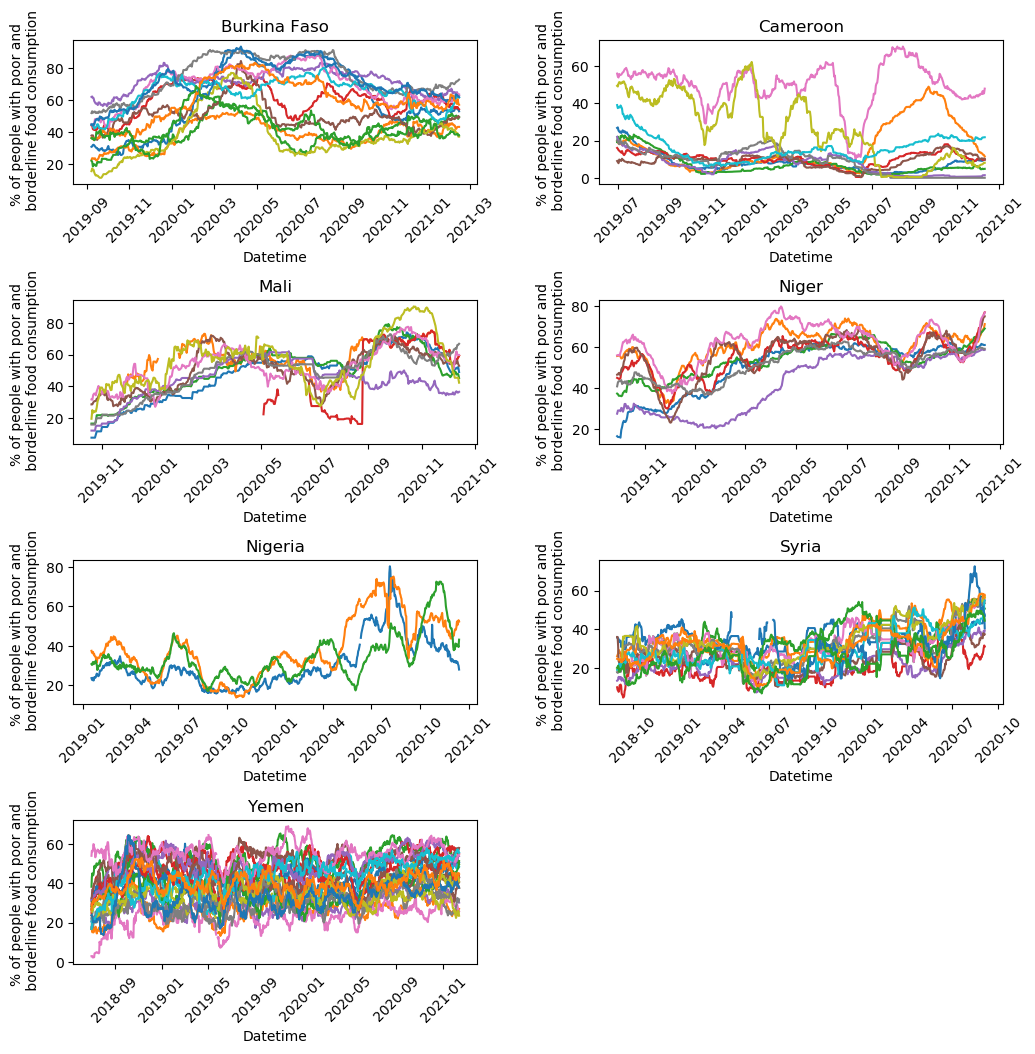

In [38]:
# Plot the original time-series of the FCG indicator for each country.
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 12))
fig.subplots_adjust(hspace = .8, wspace = .3)
axs = axs.ravel()
for i, country in enumerate(df.columns.get_level_values(0).unique()):
    axs[i].plot(df[country].xs("FCG", axis = 1, level = 1, drop_level = False))
    axs[i].set_title(country)
    axs[i].set_xlabel("Datetime")
    axs[i].set_ylabel("% of people with poor and \n borderline food consumption")
    axs[i].tick_params(axis = "x", labelrotation = 45)
    # Save just the portion of the current axes.
    extent = full_extent(axs[i]).transformed(fig.dpi_scale_trans.inverted())
    extent = axs[i].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(PATH_TO_SAVE_DATA + "%s/ts_fcs_%s.png" % (country, country), bbox_inches = extent, dpi = 300)
# Remove extra plot.
axs[-1].set_axis_off()

In [39]:
# Save the figure.
fig.savefig(PATH_TO_SAVE_DATA + "ts.png", dpi = 600, bbox_inches = "tight")

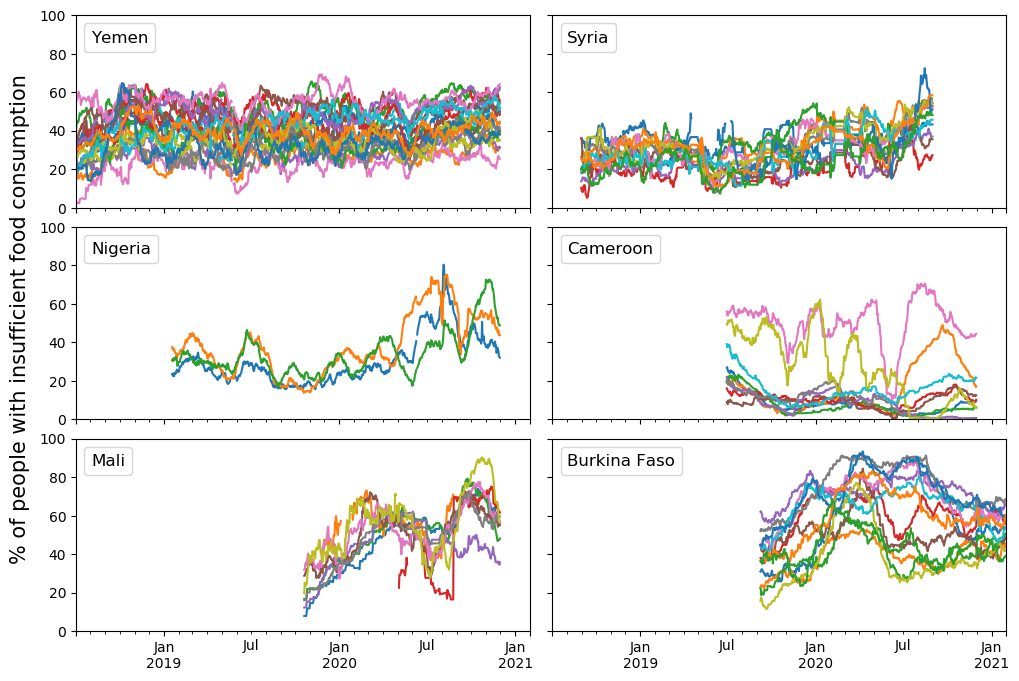

In [40]:
# Define the end reference end period of forecasting analysis.
ref_end = {"Yemen": "2020-11-30", "Syria": "2020-08-31", "Nigeria": "2020-11-30", 
           "Cameroon": "2020-11-30", "Mali": "2020-11-30", "Burkina Faso": "2021-01-31"}

# Plot the original time-series of the FCG indicator for each country.
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 8), sharex = True, sharey = True)
fig.subplots_adjust(hspace = .1, wspace = .05)
axs = axs.ravel()
for i, country in enumerate(ref_end.keys()):
    df_plot = df[country].loc[df[country].first_valid_index():ref_end[country]]
    df_plot.xs("FCG", axis = 1, level = 1, drop_level = False).plot(ax = axs[i], style = "-")
    axs[i].set_xlabel("")
    axs[i].legend_ = None
    axs[i].set_ylim(0, 100)
    axs[i].set_xlim(df.first_valid_index(), "2021-01-31")
    # Legend.
    item = Line2D([0], [0], label = country, color = "k")
    item.set_visible(False)
    axs[i].legend(handles = [item], loc = "upper left", handlelength = 0, 
                  handletextpad = 0, fancybox = True, prop = {"size": 12})

fig.text(0.07, 0.5, "% of people with insufficient food consumption", va = "center", rotation = "vertical", 
         fontdict = {"size": 15});

In [41]:
# Save the figure.
fig.savefig(PATH_TO_SAVE_DATA + "ts_forecasting_analysis.png", dpi = 600, bbox_inches = "tight")

In [42]:
# Now save the time-series at country level keeping as indeces for each group of time-series the own first and last valid indeces.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time-series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [43]:
# Save the dataframe.
df.xs("FCG", axis = 1, level = 2, drop_level = False).groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_fcs"));

## Adjustment of the time-series (interpolation NaN values)

Let's interpolate the NaN values between the first and last valid index of each time-series using a linear interpolation up to a limit of 7 days. Finally, we delete the time-series that still have some NaN values in the last temporal points.

In [44]:
# Let's interpolate the NaN values using a linear interpolation up to a limit of 7 days.
def interpolation(group):  
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    group = group.interpolate(method = "linear", limit = 7, axis = 0)
    # Delete time-series that still has some NaN values in its last temporal part.
    if group.isna().any().any():
        # Keep only last temporal part of the time-series.
        events = np.split(group, np.where(np.isnan(group.values))[0])
        # Removing NaN entries.
        events = [ev[~np.isnan(ev.values)] for ev in events if not isinstance(ev, np.ndarray)]
        # Removing empty DataFrames.
        events = [ev for ev in events if not ev.empty]
        # Last event (70%).
        last_event = events[-1]
        if len(last_event) >= int(0.7*len(group)):
            return last_event
        else:
            group.dropna(inplace = True, axis = 1)
            return group
    else:
        return group

df_interpolate = df.groupby(axis = 1, level = [0, 1, 2], group_keys = False).apply(interpolation)
df_interpolate.head()

Country          Burkina Faso                                            \
AdminStrata Boucle-Du-Mouhoun              Cascades              Centre   
Indicator                 FCG SvyDateRange      FCG SvyDateRange    FCG   
Datetime                                                                  
2018-07-02                NaN          NaN      NaN          NaN    NaN   
2018-07-03                NaN          NaN      NaN          NaN    NaN   
2018-07-04                NaN          NaN      NaN          NaN    NaN   
2018-07-05                NaN          NaN      NaN          NaN    NaN   
2018-07-06                NaN          NaN      NaN          NaN    NaN   

Country                                                                    \
AdminStrata              Centre-Est              Centre-Nord                
Indicator   SvyDateRange        FCG SvyDateRange         FCG SvyDateRange   
Datetime                                                                    
2018-07-02           NaN        NaN          NaN         NaN          NaN   
2018-07-03           NaN        NaN          NaN         NaN          NaN   
2018-07-04           NaN        NaN          NaN         NaN          NaN   
2018-07-05           NaN        NaN          NaN         NaN          NaN   
2018-07-06           NaN        NaN          NaN         NaN          NaN   

Country      ...    Yemen                                              \
AdminStrata  ...   Sa'ada                Sana'a               Shabwah   
Indicator    ...      FCG SvyDateRange      FCG SvyDateRange      FCG   
Datetime     ...                                                        
2018-07-02   ...  17.6760         31.0  26.9177         31.0  16.7523   
2018-07-03   ...  17.1346         31.0  25.7835         31.0  18.2575   
2018-07-04   ...  17.4545         31.0  25.4360         31.0  19.0831   
2018-07-05   ...  17.8463         31.0  27.4218         31.0  20.3495   
2018-07-06   ...  18.4631         31.0  26.5472         31.0  21.1075   

Country                                                               
AdminStrata               Socotra                 Taizz               
Indicator   SvyDateRange      FCG SvyDateRange      FCG SvyDateRange  
Datetime                                                              
2018-07-02          31.0  23.8228         31.0  26.5634         31.0  
2018-07-03          31.0  23.6999         31.0  29.1240         31.0  
2018-07-04          31.0  23.1032         31.0  29.4280         31.0  
2018-07-05          31.0  21.5964         31.0  30.4560         31.0  
2018-07-06          31.0  20.1291         31.0  31.0125         31.0  

[5 rows x 154 columns]

In [45]:
# Check what time-series are dropped.
for column in df.columns:
    if column not in df_interpolate.columns:
        print(column)

('Syria', 'Quneitra', 'FCG')
('Syria', 'Quneitra', 'SvyDateRange')


In [46]:
# Plot the time-series.
TsIP(df_interpolate).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with poor and borderline food consumption", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [47]:
# Plot time-series without survey coverage information.
TsIP(df_interpolate.xs("FCG", axis = 1, level = 2, drop_level = False)).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with poor and borderline food consumption", first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Cameroon', 'Mali', 'Niger…

In [48]:
# Save these new time-series.
df_interpolate.xs("FCG", axis = 1, level = 2, drop_level = False).groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_fcs-interpolate"));

In [49]:
# Save the survey coverage information of these new time-series.
df_interpolate.xs("SvyDateRange", axis = 1, level = 2, drop_level = False).groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_fcs-SvyDateRange"));